In [764]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import queue
import time
import uuid
import heapq

In [765]:
from collections import defaultdict
class Event:
    def __init__(self, timestamp, event_type, peer_id, data=None):
        self.timestamp = timestamp
        self.type= event_type
        self.peer_id = peer_id
        self.data = data
    def __lt__(self, other):
        return self.timestamp < other.timestamp
    def __repr__(self):
        return f"{str(self.timestamp)[:8]}: {self.type} by {self.peer_id}:"
class Block:
    def __init__(self, id, parent, miner, transactions, time):
        self.id = id
        self.miner = miner
        self.transactions= transactions
        self.time = time
        self.size = 1 + len(transactions)
        self.validity = True
        self.parent = parent if parent else None
        self.txn_processed = parent.txn_processed if parent else set()
        # Hey so in actual you are supposed to reverify entire chains but that would be inefficient so we are storing in each block to verify 
        self.coin_data = parent.coin_data if parent else defaultdict(lambda : 10)
        if self.miner:self.coin_data[self.miner]+=50 # Miners profit
        for txn in self.transactions:
            self.coin_data[txn.payer.id]-=txn.coins
            self.coin_data[txn.receiver.id]+=txn.coins
            self.txn_processed.add(txn)
        for item,value in self.coin_data.items():
            if value < 0 : 
                self.validity = False
                break

    def __repr__(self):
        return f"{str(self.id)[:8]}: Block created by Miner {self.miner} at {self.time} with {len(self.transactions)} txn's and is {"valid" if self.validity else "invalid"}"
class BlockchainTree:
    def __init__(self):
        self.blocks = {} 
        self.children = defaultdict(list)
        self.height = {}
        self.longest :Block|None= None

    def add_block(self, block):
        self.blocks[block.id] = block
        if block.parent:
            self.children[block.parent.id].append(block.id)
            self.height[block.id] = self.height[block.parent.id] + 1
        else:
            self.height[block.id] = 1 

        if not self.longest or self.height[block.id] > self.height[self.longest.id]:
            self.longest = block
    def get_longest_chain(self):
        chain = []
        current = self.longest
        while current:
            chain.append(current)
            current = self.blocks[current.id].parent
        return chain[::-1]  

    def visualize(self):
        G = nx.DiGraph()
        for block in self.blocks.values():
            G.add_node(block.id, label=f"Block {str(block.id)[:8]}\nMiner: {block.miner}")
            if block.parent:
                G.add_edge(block.parent.id, block.id)
        pos = nx.kamada_kawai_layout(G)  
        labels = nx.get_node_attributes(G, 'label')
        plt.figure(figsize=(12, 8))  
        nx.draw(G, pos, with_labels=True, labels=labels, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', arrows=True)
        plt.title("Blockchain Tree Visualization")
        plt.show()


In [766]:
class Transaction :
    def __init__(self,id,payer,receiver,coins):
        self.status = "Valid" if payer.coins >= coins else "Invalid"
        self.payer = payer
        self.receiver = receiver 
        self.coins = coins
        self.size = 1
        self.id  = id
    def __repr__(self):
        return f"{str(self.id)[:8]}: {self.payer.id} pays {self.receiver.id} {self.coins} coins."
    def validate(self):
        self.status = "Valid" if self.payer.coins >= self.coins else "Invalid"
        return self.status
    def update(self):
        if self.status == "Valid" :
            self.payer.coins -= self.coins
            self.receiver.coins += self.coins
            print(f"{self} \n Transaction {str(self.id)[:8]} occurred successfully")
            self.status = "Invalid"
        else :
            print(f"Transaction ID {str(self.id)[:8]} cannot be further processed.")
    def __lt__(self,other):
        return self.coins < other.coins

In [767]:
class Peer :
    def __init__(self,id,speed,inverse_cpu):
        self.id = id
        self.speed = speed
        self.inverse_cpu = inverse_cpu
        self.coins = 10000
        self.transaction_mem = set()
        self.block_chain_tree :BlockchainTree= BlockchainTree()
    def __repr__(self):
        return f"{self.id} with {self.speed} speed and {self.inverse_cpu} quality cpu has {self.coins} coins"


In [768]:
class Network:
    def __init__(self, size, bad_speed_fraction , bad_cpu_fraction):
        self.size = size
        self.Graph = nx.Graph() 
        # bad_speed_fraction + 10*(1-bad_speed_fraction) = 1/h
        # h = 1/(10-9*bad_speed_fraction)*nf
        inverse_hash_power = (10-9*bad_cpu_fraction)*size
        speed_distribution = ["Low"] * int(bad_speed_fraction * size) + ["High"] * (size-int((bad_speed_fraction) * size))
        inverse_cpu_distribution = [inverse_hash_power] * int(bad_cpu_fraction * size) + [inverse_hash_power/10] * (size - int((bad_cpu_fraction) * size) )
        random.shuffle(speed_distribution)
        random.shuffle(inverse_cpu_distribution)
        for i in range(size):
            peer = Peer(i,speed_distribution[i],inverse_cpu_distribution[i])
            self.Graph.add_node(i, peer=peer)
        while not (self.check_connectivity() and nx.is_connected(self.Graph)):
            print("Generated a not connected graph retrying...")
            if (self.check_connectivity() != nx.is_connected(self.Graph)):
                print("Sorry the connectivity function never showed an error while testing but is currently misbehaving")
            self.Graph.clear_edges()
            self.generate_edges(3,6)
    def check_connectivity(self):
        visited = [False for _ in range(self.size)]
        q = queue.Queue()
        q.put(0)
        while not q.empty() :
            top = q.get()
            for node in self.Graph[top]:
                if not visited[node]:
                    q.put(node)
                    visited[node]=True
        return all(visited)
    def generate_edges(self,lower_limit,upper_limit,timeout = 2.0):
        Graph = self.Graph
        start_time = time.time()
        for node in list(Graph.nodes):
            if Graph.degree[node] > upper_limit:
                Graph.clear_edges()
                self.generate_edges(lower_limit,upper_limit)            
            new_no_edges = random.randint(max(lower_limit-Graph.degree[node],0),upper_limit-Graph.degree[node])
            for _ in range(new_no_edges):
                while True:
                    if time.time() - start_time > timeout:
                        print(f"Timeout while generating edges for node {node}")
                        Graph.clear_edges()
                        self.generate_edges(lower_limit,upper_limit)
                        return 
                    adj_node = random.randint(0,self.size-1)
                    if adj_node != node and Graph.degree[adj_node] < upper_limit:
                        Graph.add_edge(node,adj_node)
                        break
    def get_peer_info(self, node_id)->Peer:
        return self.Graph.nodes[node_id]['peer']
    def visualize_network(self):
        node_colors = "skyblue"
        node_sizes = [20 + 50 * self.Graph.degree(n) for n in self.Graph.nodes()]
        pos = nx.kamada_kawai_layout(self.Graph)
        plt.figure(figsize=(12, 9))
        nx.draw_networkx_nodes(self.Graph, pos,node_color=node_colors,node_size=node_sizes,alpha=1,edgecolors='black', linewidths=1)
        nx.draw_networkx_edges(self.Graph, pos,edge_color='gray',alpha=1,width=1.2)
        nx.draw_networkx_labels(self.Graph, pos,font_size=8,font_color='black')
        plt.title("Peer to Peer network",fontsize=16)
        plt.axis('off')
        plt.show()

In [769]:
rho_ij = random.uniform(0.01,0.5)
print(rho_ij)

0.113082535675003


In [770]:
def calculate_latency(Peer_1:Peer,Peer_2:Peer,msg:Transaction):
    c_ij = 100 * 1024  if Peer_1.speed == "High" and Peer_2.speed == "Low" else 5 * 1024 
    d_ij = random.expovariate(c_ij/96)
    return rho_ij + msg.size/c_ij + d_ij

In [771]:
def propagate_msg(msg, root: Peer, Network: Network):
    if root.__class__ == Peer:root_id = root.id
    else :root_id = root
    Graph = Network.Graph
    received_time = [float('inf') for _ in range(Network.size)]
    received_time[root_id] = 0
    pq = [(0, root_id)]
    heapq.heapify(pq)
    while pq:
        current_time, current_peer_id = heapq.heappop(pq)
        for neighbor in Graph.neighbors(current_peer_id):
            latency = calculate_latency(Network.get_peer_info(current_peer_id), Network.get_peer_info(neighbor), msg)
            new_time = current_time + latency  
            if new_time < received_time[neighbor]:
                received_time[neighbor] = new_time
                heapq.heappush(pq, (new_time, neighbor))
    return received_time

In [772]:
Ttx,I,block_size = 10,600,1023
class Simulator():
    def __init__(self,size):
        self.time = 0
        self.events = []
        self.size = size
        self.Network = Network(size,0.1,0.2)
        Genesis = Block(uuid.uuid4(),None,None,[],0)
        for i in range(self.Network.size):
            heapq.heappush(self.events,Event(0,"Rec_block",i,Genesis))
            receiver = random.randint(0, self.size - 1)
            while receiver == i:
                receiver = random.randint(0, self.size - 1)
            receiver = self.Network.get_peer_info(receiver)
            heapq.heappush(self.events,Event(self.time+random.expovariate(1/Ttx),"Gen_txn",i,Transaction(uuid.uuid4(),self.Network.get_peer_info(i),receiver,random.randint(0,100))))
    def handle_events(self,event:Event) :
        if event.type == "Gen_txn":
            receiver = random.randint(0, self.size - 1)
            while receiver == event.peer_id:
                receiver = random.randint(0, self.size - 1)
            receiver = self.Network.get_peer_info(receiver)
            heapq.heappush(self.events,Event(self.time+random.expovariate(1/Ttx),"Gen_txn",event.peer_id,Transaction(uuid.uuid4(),self.Network.get_peer_info(event.peer_id),receiver,random.randint(0,100))))
            received_time_delay = propagate_msg(event.data,event.peer_id,self.Network)
            for i in range(self.Network.size):
                person : Peer = self.Network.get_peer_info(i)
                # heapq.heappush(person.transaction_mem,(received_time_delay[i]+event.timestamp,event.data))
                heapq.heappush(self.events,Event(received_time_delay[i]+event.timestamp,"Rec_txn",i,event.data))
        elif event.type == "Rec_txn":
            self.Network.get_peer_info(event.peer_id).transaction_mem.add(event.data)
        elif event.type == "Rec_block":
            if event.data.validity:
                Person : Peer = self.Network.get_peer_info(event.peer_id)
                prev_longest = Person.block_chain_tree.longest
                Person.block_chain_tree.add_block(event.data)
                new_longest = Person.block_chain_tree.longest
                if prev_longest!=new_longest:
                    rem_txns : list[Transaction]= Person.transaction_mem - new_longest.txn_processed
                    txns = []
                    temp_balances = new_longest.coin_data.copy()
                    for txn in rem_txns:
                        if temp_balances[txn.payer.id] >= txn.coins:
                            temp_balances[txn.payer.id] -= txn.coins
                            temp_balances[txn.receiver.id] += txn.coins
                            txns.append(txn)
                        if len(txns) >= block_size:
                            break
                    new_block = Block(uuid.uuid4(),new_longest,Person.id,txns,event.timestamp + random.expovariate(1/(Person.inverse_cpu*I)))
                    e = Event(event.timestamp + random.expovariate(1/(Person.inverse_cpu*I)),"Gen_block",event.peer_id,new_block)
                    heapq.heappush(self.events,e)
        elif event.type == "Gen_block":
            Person : Peer = self.Network.get_peer_info(event.peer_id)
            gen_block : Block = event.data
            if gen_block.parent == Person.block_chain_tree.longest:
                delay = propagate_msg(gen_block,Person,self.Network)
                for i in range(self.Network.size):
                    heapq.heappush(self.events,Event(event.timestamp + delay[i],"Rec_block",i,gen_block))
    def simulate(self,time):
        while self.time < time:
            if not self.events: break
            event:Event = heapq.heappop(self.events)
            self.handle_events(event)
            self.time  = event.timestamp
        while self.events:
            e = heapq.heappop(self.events)


In [773]:
sim = Simulator(10)

Generated a not connected graph retrying...


In [774]:
sim.simulate(10000)
for i in range(sim.size):
    Person = sim.Network.get_peer_info(i)
    print(Person)
    print(Person.block_chain_tree.longest.coin_data)
    print(Person.block_chain_tree.get_longest_chain())

0 with High speed and 8.2 quality cpu has 10000 coins
defaultdict(<function Block.__init__.<locals>.<lambda> at 0x0000017C01C81F80>, {1: 3623, 3: 13, 7: 15, 6: 11, 2: 0, 5: 1778, 4: 13, 9: 37, 8: 6, 0: 4})
[5de770a8: Block created by Miner None at 0 with 0 txn's and is valid, 23f311f1: Block created by Miner 5 at 11383.822536298849 with 0 txn's and is valid, 7e1271d1: Block created by Miner 3 at 5932.086718639976 with 1 txn's and is valid, 3f2b3aac: Block created by Miner 9 at 1514.7385944589414 with 0 txn's and is valid, d76a8480: Block created by Miner 9 at 2947.7870901678352 with 331 txn's and is valid, 93eae31b: Block created by Miner 9 at 15922.6143991599 with 1023 txn's and is valid, da1a2917: Block created by Miner 0 at 7493.388241775076 with 6 txn's and is valid, ddb4e790: Block created by Miner 9 at 8033.272616762789 with 4 txn's and is valid, bf5765b8: Block created by Miner 9 at 8763.513435523757 with 355 txn's and is valid, 523bd81f: Block created by Miner 0 at 15356.396894

In [775]:
i=0

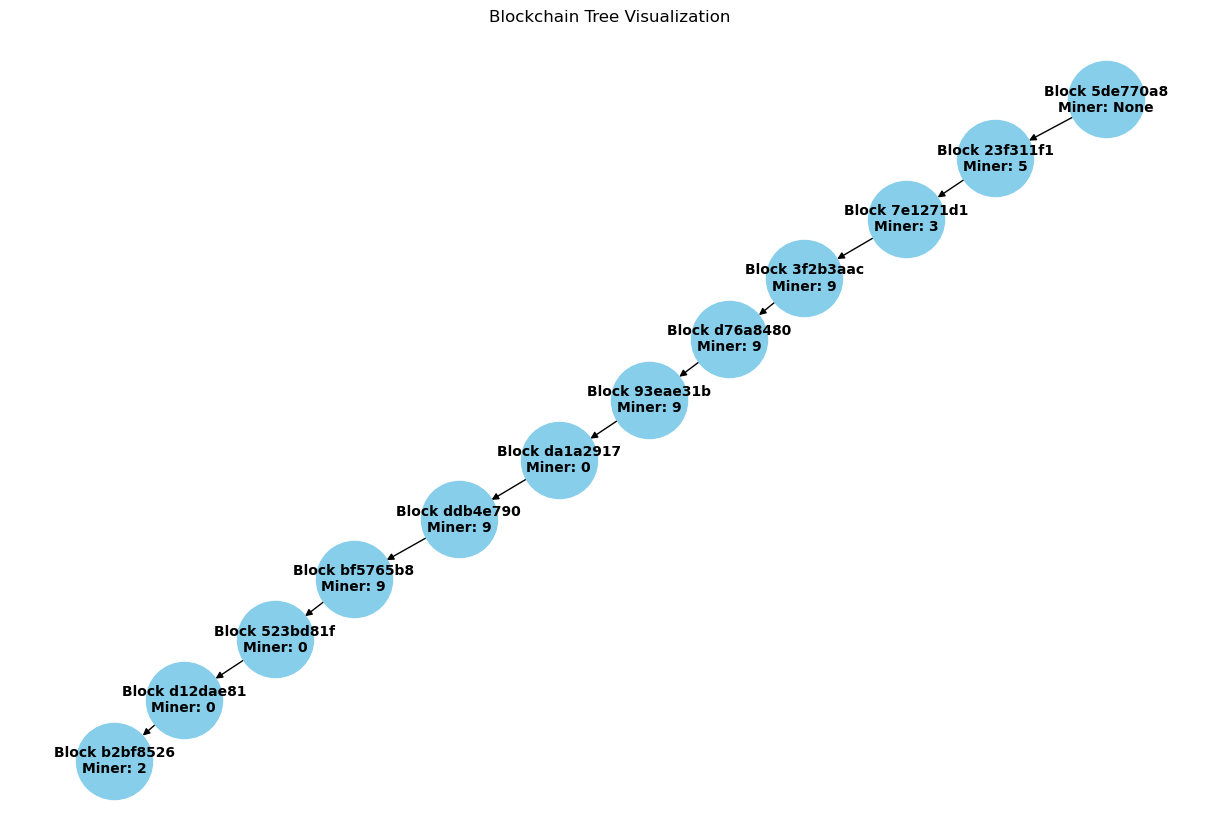

In [776]:
Person = sim.Network.get_peer_info(i)
Person.block_chain_tree.visualize()
i+=1